In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
% cd /content/drive/MyDrive/MIPT/ocr/course_ocr/task2

In [ ]:
! pip install pytorch-lightning
! pip install wandb
! pip install pytorch-metric-learning

In [ ]:
! pip install -e .

In [5]:
import os
import cv2
import csv
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
from time import time
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.utils as vutils
from torchvision import models
from torchvision import transforms as VT

import pytorch_lightning as pl
from pytorch_metric_learning import losses

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import wandb
wandb.login()

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

wandb: Currently logged in as: taya. Use `wandb login --relogin` to force relogin


In [7]:
from data_reader import Vocabulary, HWDBDatasetHelper, ArchivedHWDBReader
from course_ocr_t2.evaluate import evaluate

## Data preparation

In [8]:
train_path = '/content/drive/MyDrive/MIPT/ocr/course_ocr/task2/data/train.zip'
test_path = '/content/drive/MyDrive/MIPT/ocr/course_ocr/task2/data/test.zip'
pred_path = './pred.txt'
gt_path = './gt.txt'

In [9]:
train_reader = ArchivedHWDBReader(train_path)
train_reader.open()
train_helper = HWDBDatasetHelper(train_reader)

In [9]:
train_helper, val_helper = train_helper.train_val_split()
train_helper.size(), val_helper.size()

(2578433, 644609)

In [10]:
class SymDataset(Dataset):
    def __init__(self, helper: HWDBDatasetHelper):
        self.helper = helper           

    def __getitem__(self, index):
        img, label = self.helper.get_item(index)
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 11)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = (cv2.resize(img, (64, 64)) - 127.5) / 255.
        return img, label

    def __len__(self):
        return self.helper.size()

In [11]:
train_dataset = SymDataset(train_helper)
val_dataset = SymDataset(val_helper)

In [22]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=True, num_workers=0)

## Model

In [11]:
class Classifier(pl.LightningModule):
    def __init__(self, num_classes=7330, embedding_size=512):
        super().__init__()
        self.metric = losses.ArcFaceLoss(num_classes=num_classes, embedding_size=embedding_size)
        self.save_hyperparameters()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, embedding_size)

    def forward(self, imgs):
        embs = self.model(imgs)
        return embs

    def training_step(self, batch, batch_idx):
        torch.cuda.empty_cache()
        imgs, labels = batch
        embs = self(imgs.float().permute(0, 3, 1, 2))
        loss = self.metric(embs, labels)
        self.log("train/loss", loss, on_step=True, on_epoch=True)
        self.log("lr", self.optimizer.param_groups[0]['lr'])
        return loss

    def validation_step(self, batch, batch_idx):
        torch.cuda.empty_cache()
        imgs, labels = batch
        embs = self(imgs.float().permute(0, 3, 1, 2))
        loss = self.metric(embs, labels)
        logits = self.metric.get_logits(embs)
        labels_hat = torch.argmax(logits, dim=1)
        acc = torch.sum(labels == labels_hat).item() / (len(labels) * 1.0)
        self.log("val/loss", loss, on_step=True, on_epoch=True)
        self.log("val/acc", acc, on_step=True, on_epoch=True)
        self.log("lr", self.optimizer.param_groups[0]['lr'])
        return loss

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        # self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', factor=0.5, threshold=1e-8)
        # lr_scheduler = {"scheduler": self.scheduler, "interval": "epoch", "monitor": "val/loss"}
        return {
            "optimizer": self.optimizer,
            # "lr_scheduler": lr_scheduler
        }

In [ ]:
classifier = Classifier()

wandb.finish()
wandb_logger = WandbLogger(project="OCR_2")
trainer = Trainer(max_epochs=5, accelerator="gpu", logger=wandb_logger)
trainer.fit(model=classifier, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

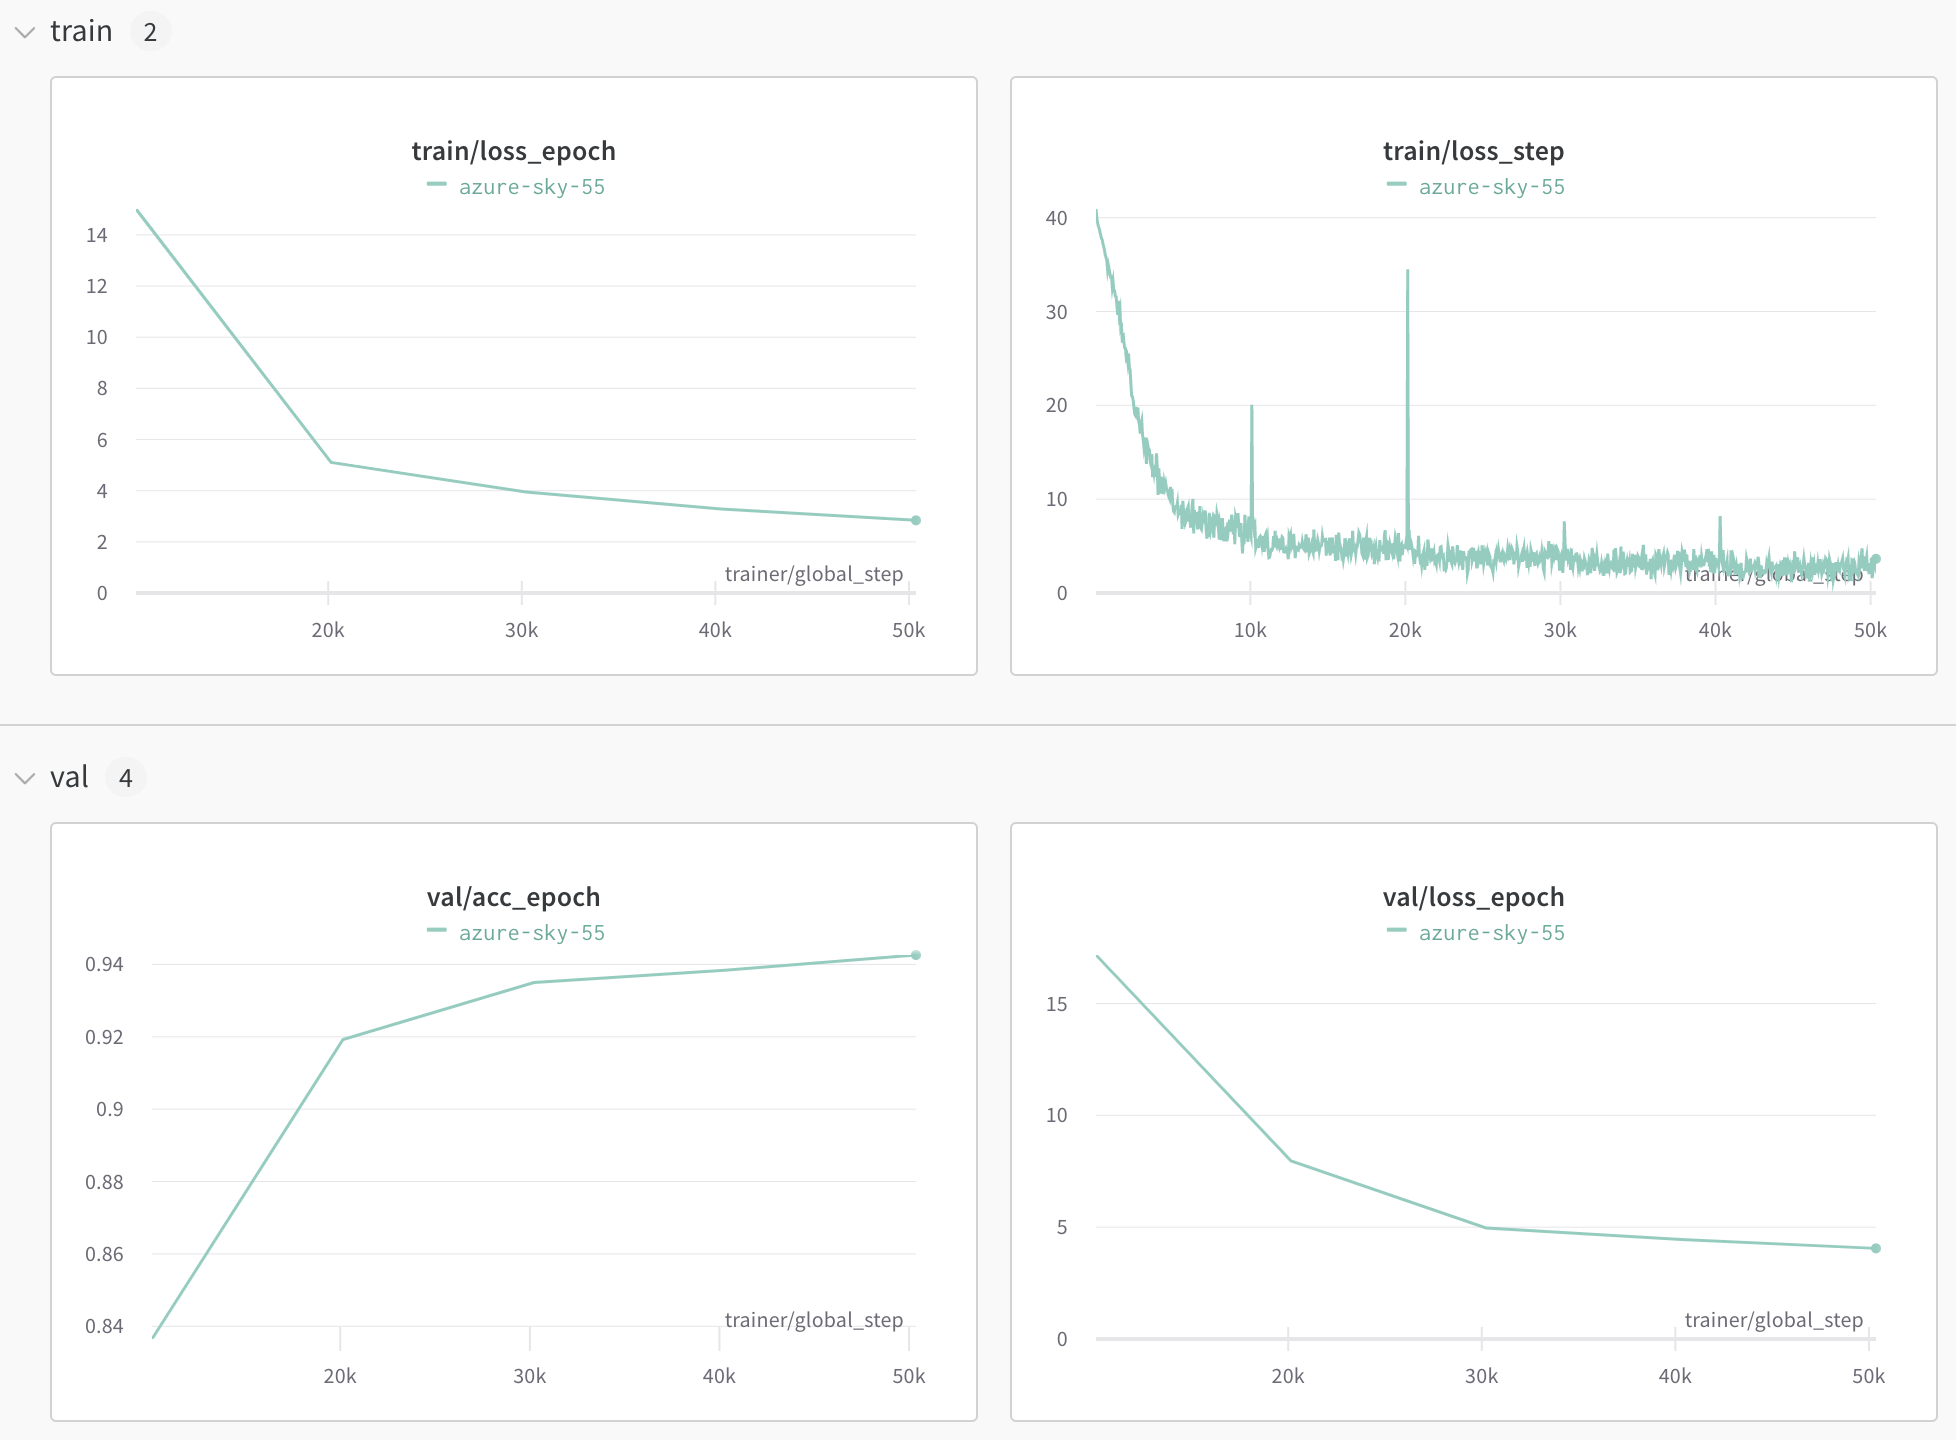

In [25]:
trainer.save_checkpoint("/content/drive/MyDrive/MIPT/ocr/course_ocr/task2/%s.ckpt" % wandb.run.name)

## Evaluation

In [12]:
test_reader = ArchivedHWDBReader(test_path)
test_reader.open()
test_helper = HWDBDatasetHelper(test_reader, prefix='Test')
test_dataset = SymDataset(test_helper)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=0)

In [13]:
preds = []

classifier = Classifier.load_from_checkpoint("/content/drive/MyDrive/MIPT/ocr/course_ocr/task2/%s.ckpt" % 'azure-sky-55').to(device)
classifier.eval()

arcface_w = torch.load("/content/drive/MyDrive/MIPT/ocr/course_ocr/task2/%s.ckpt" % 'azure-sky-55')['state_dict']['metric.W']
arc_dict = {'W': arcface_w}
arcface = losses.ArcFaceLoss(num_classes=7330, embedding_size=512).to(device)
arcface.load_state_dict(arc_dict)

with torch.no_grad():
    for imgs, _ in tqdm(test_dataloader):
        embs = classifier(imgs.float().permute(0, 3, 1, 2).to(device))
        classes = torch.argmax(arcface.get_logits(embs), dim=1).cpu().numpy()
        preds.extend(classes)   

In [14]:
with open(pred_path, 'w') as f_pred:
    for idx, pred in enumerate(preds):
        name = test_helper.namelist[idx]
        cls = train_helper.vocabulary.class_by_index(pred)
        print(name, cls, file=f_pred)

In [15]:
score = evaluate(gt_path, pred_path)
print('Accuracy = {:1.4f}'.format(score))

Accuracy = 0.9179
